# Imports

In [1]:
import pandas as pd
import tashaphyne.normalize as tn
import emoji

# Working with data

## Reading Data
store both positive and negative data into a dataframe<br> 
label them accordingly and then combine them<br>
<b>Note:</b> the data will be shuffled later on..

In [2]:
data_pos = pd.read_csv('pos.txt', sep="\t", header=None, names=["text"])
data_neg = pd.read_csv('neg.txt', sep="\t", header=None, names=["text"])
data_mixed = pd.read_csv('mixed.txt', sep="\t", header=None, names=["text", 'label'])

data_pos['label'] = 1
data_neg['label'] = 0
data_mixed['label'] = data_mixed['label'].map({'NEG': 0, 'POS': 1, 'OBJ': -1, 'NEUTRAL': -1})
data_mixed['label'] = data_mixed['label'].astype('int')
data_mixed.drop(data_mixed[data_mixed['label'] == -1].index, inplace=True)

data = pd.concat([data_pos, data_neg, data_mixed]).reset_index(drop=True)

## Data Preprocessing
Removed punctuation, diacritics, emojies, numbers, links, hashtags, english letters, special characters, and normalized text

In [3]:
import re
import string
from nltk.corpus import stopwords # list of stop words

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("يٰ", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def clean_text(text):
    text = emoji.get_emoji_regexp().sub(u'', text)
    text = re.sub(u"[^\w^\u0600-\u06FF]", ' ', text)
    
    text = normalize_arabic(text)
    text = remove_punctuations(text)
    text = remove_diacritics(text)
    text = remove_repeating_char(text)
    
    text = re.sub("[a-zA-Z_]", " ", text) # remove english letters
    text = re.sub('\n', ' ', text) # remove \n from text
    text = re.sub(r'\d+', '', text) #remove number
    text = re.sub(r'http\S+', '', text) # remove links
    text.replace("#", "")# remove hash tags and 
    text.replace("_", " ")# remove underscores
    text = text.strip() #remove whitespaces
    text = ' '.join([word for word in text.split() if word not in stopwords.words("arabic")]) # remove stop word
    
    text = tn.normalize_searchtext(text)
    
    return text

In [4]:
print(data['text'][1001])
print(data['text'][1])

#ياارب كل ما انقبضت قلوبنا من هم الدنيا ذكرنا بالصبر الجميل وأنكك المستعاان ##صبااحﺢ_الخيرر 🍁
وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال في روحك أماالمنبهرون بالمظا…


In [5]:
data['text'] = data['text'].apply(clean_text)

In [6]:
print(data['text'][1001])
print(data['text'][1])

يارب انقبضت قلوبنا الدنيا ذكرنا بالصبر الجميل وانك المستعان صباحﺢالخير
وفي النهايه يبقي معك احدالا راي الجمال روحك امالمنبهرون بالمظا


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data.label, test_size=0.2, random_state=43)

# MultinomialNB

In [9]:
modelM = MultinomialNB(alpha=0.05)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('model', modelM)
])

In [10]:
from sklearn.metrics import accuracy_score
# Fitting the model
modelM = pipeline.fit(X_train, y_train)
# Accuracy
prediction = modelM.predict(X_test)
scoreM = round(accuracy_score(y_test, prediction)*100,2)
print("accuracy: {}%".format(scoreM))

accuracy: 80.02%


In [26]:
text =['أكرة نفسي']
pred = modelM.predict(text)
pred[0]

0

In [12]:
text =['انا مرة سعيد اليوم']
pred = modelM.predict(text)
pred[0]

1

# BernoulliNB

In [13]:
modelB = BernoulliNB(alpha=0.05)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('model', modelB),
])

In [14]:
# Fitting the model
modelB = pipeline.fit(X_train, y_train)
# Accuracy
prediction = modelB.predict(X_test)
scorB = round(accuracy_score(y_test, prediction)*100,2)
print("accuracy: {}%".format(scorB))

accuracy: 79.61%


In [27]:
text =['أكرة نفسي']
pred = modelM.predict(text)
pred[0]

0

In [16]:
text =['انا مرة سعيد اليوم']
pred = modelM.predict(text)
pred[0]

1

# Visualize

In [17]:
import numpy as np
import matplotlib.pyplot as plt
test_data = pd.concat([X_test, y_test], axis=1)

positive = test_data[test_data['label'] == 1]
negative = test_data[test_data['label'] == 0]

X_positive = positive['text']
y_positive = positive['label']

X_negative = negative['text']
y_negative = negative['label']

### BernoulliNB

In [18]:
# Accuracy on positive
predPB = modelB.predict(X_positive)
scorPos = round(accuracy_score(y_positive, predPB)*100,2)

# Accuracy on negative
predNB = modelB.predict(X_negative)
scorNeg = round(accuracy_score(y_negative, predNB)*100,2)

### Barchart

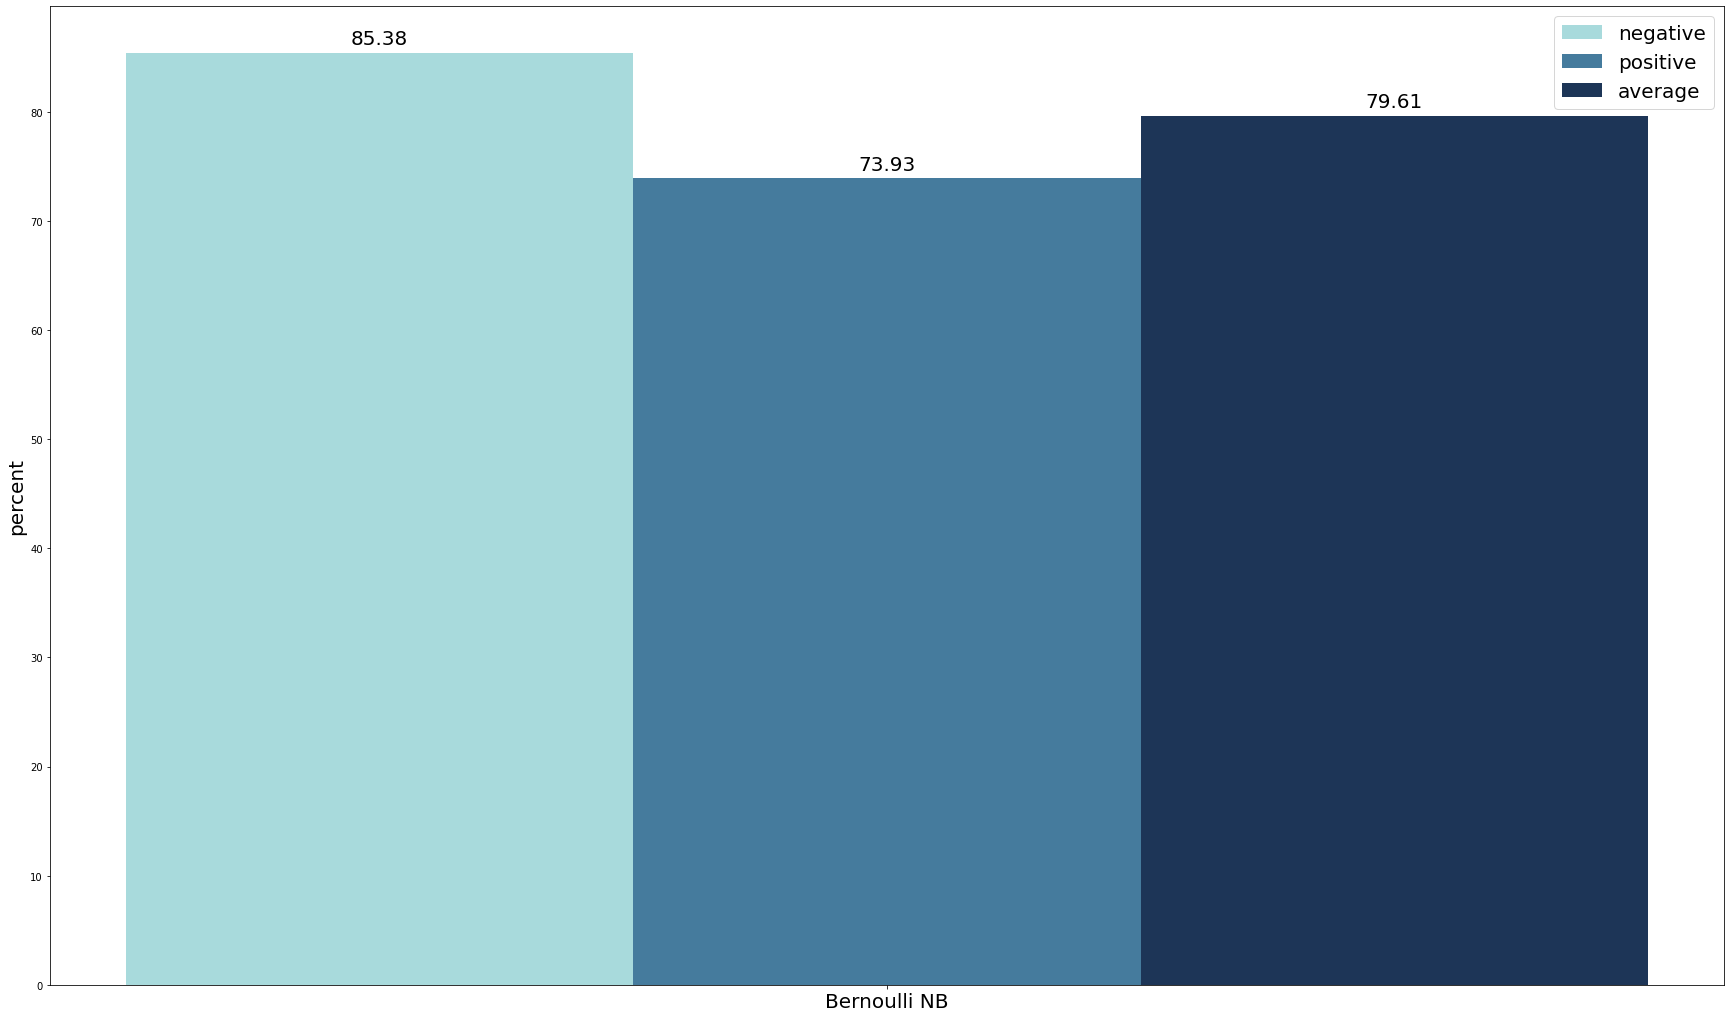

In [19]:
N = 1
ind = np.arange(N)  # the x locations for the groups
width = 0.1       # the width of the bars

fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(111)

yvals = [scorNeg]
rects1 = ax.bar(ind, yvals, width, color='#a8dadc')
zvals = [scorPos]
rects2 = ax.bar(ind+width, zvals, width, color='#457b9d' )
kvals = [scorB]
rects3 = ax.bar(ind+width*2, kvals, width, color='#1d3557')

ax.set_ylabel('percent', fontsize= 20)
ax.set_xticks(ticks=ind+width)
ax.set_xticklabels( ('Bernoulli NB', ) , fontsize= 20)
ax.legend( (rects1[0], rects2[0], rects3[0]), ('negative', 'positive', 'average'), fontsize= 20 )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.005*h, (h),
                ha='center', va='bottom', fontsize= 20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

## MultinomialNB

In [20]:
# Accuracy on positive
predPM = modelM.predict(X_positive)
scorPos = round(accuracy_score(y_positive, predPM)*100,2)

# Accuracy on negative
predNM = modelM.predict(X_negative)
scorNeg = round(accuracy_score(y_negative, predNM)*100,2)

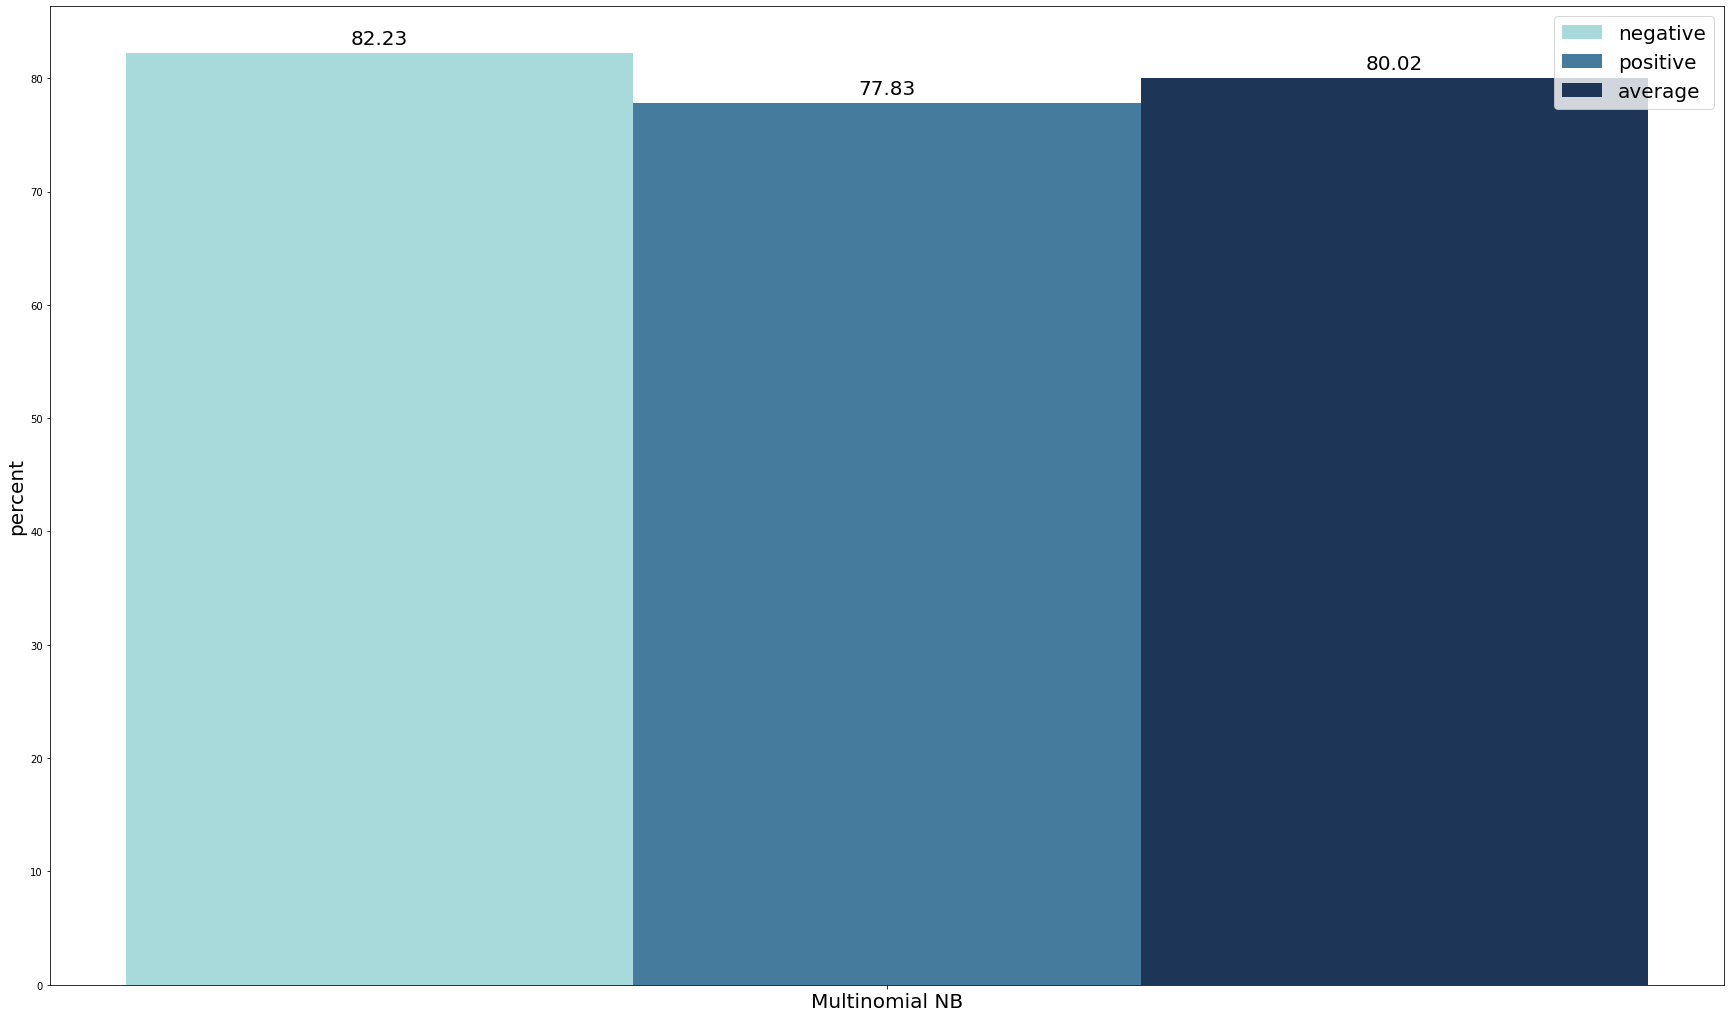

In [21]:
N = 1
ind = np.arange(N)  # the x locations for the groups
width = 0.1       # the width of the bars

fig = plt.figure(figsize=(30,18))
ax = fig.add_subplot(111)

yvals = [scorNeg]
rects1 = ax.bar(ind, yvals, width, color='#a8dadc')
zvals = [scorPos]
rects2 = ax.bar(ind+width, zvals, width, color='#457b9d' )
kvals = [scoreM]
rects3 = ax.bar(ind+width*2, kvals, width, color='#1d3557')

ax.set_ylabel('percent', fontsize= 20)
ax.set_xticks(ticks=ind+width)
ax.set_xticklabels( ('Multinomial NB', ) , fontsize= 20)
ax.legend( (rects1[0], rects2[0], rects3[0]), ('negative', 'positive', 'average'), fontsize= 20 )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.005*h, (h),
                ha='center', va='bottom', fontsize= 20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

# Storing model

In [22]:
import joblib

In [23]:
joblib.dump(modelM, 'modelmultinomialJoblib')

['modelmultinomialJoblib']

In [24]:
mj = joblib.load('modelmultinomialJoblib')

In [28]:
test_text = ['اخ الحياة 😭']
pred = mj.predict(test_text)
pred[0]

0